In [2]:
import os
print(os.listdir())

['.idea', '.ipynb_checkpoints', 'a-simple-plot.png', 'baseline_lgb.csv', 'dataread.ipynb', 'datashow.py', 'gulala.ipynb', 'input', 'read.py', 'results.zip', 'sample_submission_v2.csv', 'simple model.ipynb', 'test-flattened.csv', 'test_v2.csv', 'train-flattened.csv', 'train_v2.csv']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline


In [16]:
x=pd.Series(['','.'])

In [17]:
if x.dtype == 'object':
    print(True)

True


In [24]:
train = pd.read_csv('train_v2.csv', dtype='object', nrows=200, encoding='utf-8')

In [25]:
train.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


In [31]:
train = pd.read_csv('extracted_fields_train', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('extracted_fields_test',
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

In [32]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [33]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

In [53]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1.472830e+09,1.0,1.472830e+09,Chrome,desktop,0.0,...,1.0,1.0,1.0,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1.472880e+09,1.0,1.472880e+09,Firefox,desktop,0.0,...,1.0,1.0,1.0,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1.472865e+09,1.0,1.472865e+09,Chrome,desktop,0.0,...,1.0,1.0,1.0,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1.472881e+09,1.0,1.472881e+09,UC Browser,desktop,0.0,...,1.0,1.0,1.0,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1.472823e+09,2.0,1.472823e+09,Chrome,mobile,1.0,...,1.0,NaN,1.0,NaN,(not set),1.0,(not provided),organic,NaN,google


In [35]:
import numpy as np
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)


2

In [36]:

KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


In [87]:
X=np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]])
y=np.array([1,2,3,4,5,6])
groups=np.array([1,2,3,4,5,6])
group_kfold=GroupKFold(n_splits=3)
group_kfold.get_n_splits(X,y,groups)
print(group_kfold)
for train_index,test_index in group_kfold.split(X,y,groups):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    print(X_train,X_test,y_train,y_test)

GroupKFold(n_splits=3)
Train Index: [0 1 3 4] ,Test Index: [2 5]
[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]] [[ 5  6]
 [11 12]] [1 2 4 5] [3 6]
Train Index: [0 2 3 5] ,Test Index: [1 4]
[[ 1  2]
 [ 5  6]
 [ 7  8]
 [11 12]] [[ 3  4]
 [ 9 10]] [1 3 4 6] [2 5]
Train Index: [1 2 4 5] ,Test Index: [0 3]
[[ 3  4]
 [ 5  6]
 [ 9 10]
 [11 12]] [[1 2]
 [7 8]] [2 3 5 6] [1 4]


In [68]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [69]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom
0,Organic Search,2016-09-02 15:33:05,1131660440785968503,1131660440785968503_1472830385,1.472830e+09,1.0,1.472830e+09,Chrome,desktop,0.0,...,NaN,(not set),NaN,(not provided),organic,NaN,google,4,15,2
1,Organic Search,2016-09-03 05:22:27,377306020877927890,377306020877927890_1472880147,1.472880e+09,1.0,1.472880e+09,Firefox,desktop,0.0,...,NaN,(not set),NaN,(not provided),organic,NaN,google,5,5,3
2,Organic Search,2016-09-03 01:16:26,3895546263509774583,3895546263509774583_1472865386,1.472865e+09,1.0,1.472865e+09,Chrome,desktop,0.0,...,NaN,(not set),NaN,(not provided),organic,NaN,google,5,1,3
3,Organic Search,2016-09-03 05:40:13,4763447161404445595,4763447161404445595_1472881213,1.472881e+09,1.0,1.472881e+09,UC Browser,desktop,0.0,...,NaN,(not set),NaN,google + online,organic,NaN,google,5,5,3
4,Organic Search,2016-09-02 13:23:20,27294437909732085,27294437909732085_1472822600,1.472823e+09,2.0,1.472823e+09,Chrome,mobile,1.0,...,NaN,(not set),1.0,(not provided),organic,NaN,google,4,13,2


In [70]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [75]:
if train['device.browser'].dtype== 'object':
    print(True)


In [74]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [77]:
pd.factorize(train['sess_date_dow'])  

(array([0, 1, 1, ..., 6, 2, 2], dtype=int64),
 Int64Index([4, 5, 3, 6, 0, 1, 2], dtype='int64'))

In [78]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom']
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.66095	valid_0's l2: 2.75876
[200]	valid_0's rmse: 1.64559	valid_0's l2: 2.70796
[300]	valid_0's rmse: 1.64312	valid_0's l2: 2.69984
[400]	valid_0's rmse: 1.64121	valid_0's l2: 2.69356
[500]	valid_0's rmse: 1.64067	valid_0's l2: 2.69179
[600]	valid_0's rmse: 1.63982	valid_0's l2: 2.68899
Early stopping, best iteration

1.6314694795822213

In [86]:
len(folds[0][0])

722546

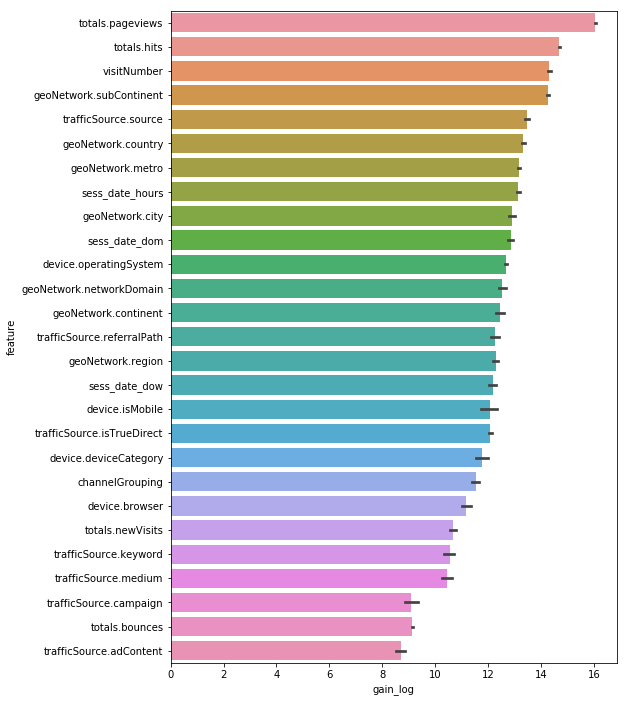

In [98]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

,A
0,True
1,False
2,True


array([0, 1, 2])

array([0, 2])